In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
import cnmfsns as cn
cn.start_logging()

## Working with `Dataset` objects

Datasets can be created from pandas DataFrames quite easily.

In [3]:
import pandas as pd

data = pd.read_table("diamandis_data/diamandis_nobulk.txt", index_col=0)  # normalized expression data
metadata = pd.read_table("diamandis_data/diamandis_nobulk.metadata.txt", index_col=0)  # sample metadata

# create dataset from DataFrames
diamandis = cn.Dataset.from_df(data=data, obs=metadata, is_normalized=True, patient_id_col="patient_id")

They can be written to and read from AnnData files (h5ad format).

In [4]:
diamandis.write_h5ad("diamandis.h5ad")  # write to .h5ad file
diamandis = cn.Dataset.from_h5ad("diamandis.h5ad")  # read a .h5ad file

2023-03-14 12:14:22,379 [INFO] Writing to /home/tbverhey/github/cNMF-SNS/example/diamandis.h5ad
2023-03-14 12:14:22,414 [INFO] Done


`Dataset` objects contain an AnnData object which can also be used for interfacing with other tools

In [5]:
diamandis.adata

AnnData object with n_obs × n_vars = 77 × 3560
    obs: 'patient_id', 'simple_category', 'detailed_category', 'age', 'sex', 'location of resection', 'ATRX', 'p53', 'MGMT'
    uns: 'cnmfsns_version', 'history', 'is_normalized', 'odg'

cNMF-SNS can recognize and import AnnData .h5ad files whether they are created in [Seurat](https://satijalab.org/seurat/archive/v2.4/conversion_vignette.html), [scanpy](https://scanpy.readthedocs.io/en/stable/usage-principles.html#anndata), or other single-cell software tools.

In [6]:
import scanpy

pbmc_adata = scanpy.datasets.pbmc3k()
pbmc_dataset = cn.Dataset.from_anndata(pbmc_adata)

## Modelling mean and dispersion of genes

In [7]:
diamandis.compute_gene_stats()
diamandis.adata.var.head()  # results are stored in dataset object

,mean,rank_mean,variance,sd,missingness,log_mean,log_variance,mean_counts,odscore_excluded,resid_log_variance,odscore,gam_fittedvalues,vscore
A1BG,1.839333e+07,2152.0,1.787097e+14,1.336824e+07,0.0,7.264660,14.252150,1.839333e+07,False,0.090640,1.109992,14.161510,1.621348
A2M,2.338366e+08,3351.0,2.278611e+16,1.509507e+08,0.0,8.368914,16.357672,2.338366e+08,False,0.040063,1.047204,16.317609,4.806647
AAAS,2.478940e+06,203.0,9.438756e+11,9.715326e+05,0.0,6.394266,11.974916,2.478940e+06,False,-0.186994,0.806312,12.161910,0.077113
AAK1,1.713328e+07,2096.0,2.520759e+14,1.587690e+07,0.0,7.233840,14.401531,1.713328e+07,False,0.294975,1.404389,14.106556,2.489859
AARS1,1.069756e+08,3146.0,9.684865e+14,3.112052e+07,0.0,8.029285,14.986094,1.069756e+08,False,-0.652043,0.472040,15.638137,0.763087


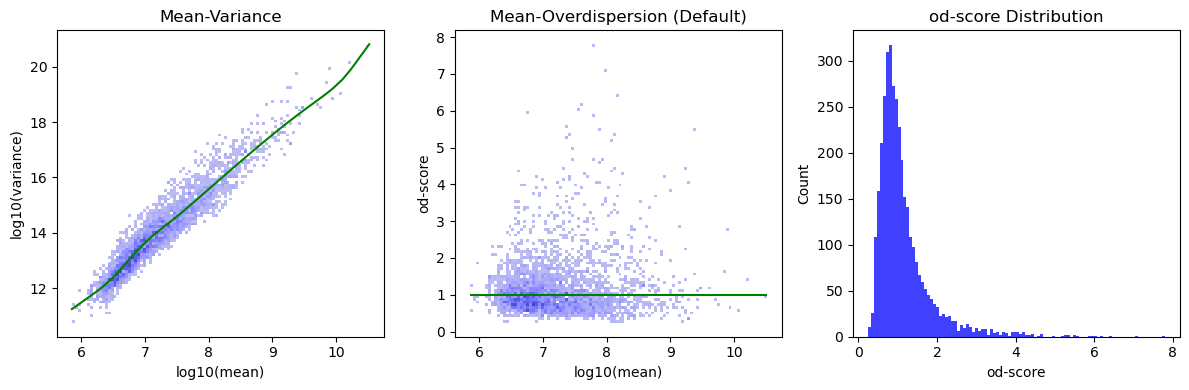

In [8]:
figs = cn.plot_feature_dispersion(diamandis)

## Selecting overdispersed genes

2023-03-14 12:14:26,512 [INFO] 1612 genes selected for factorization


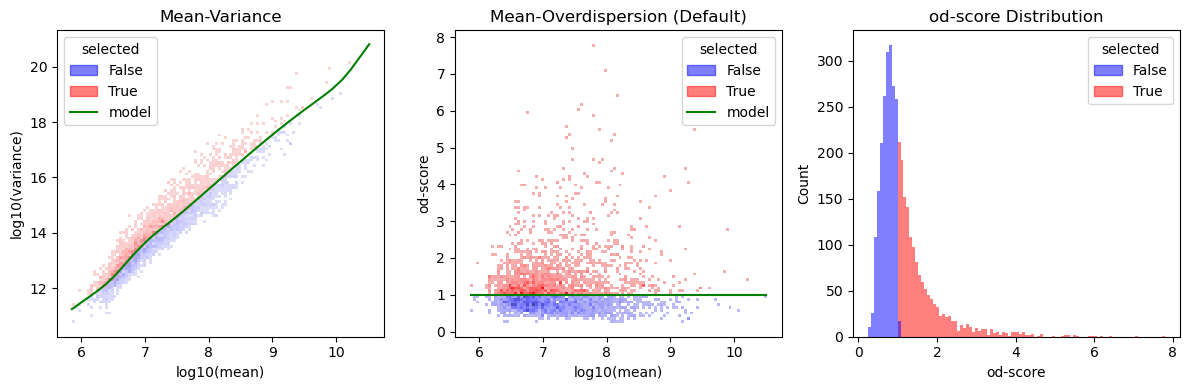

In [9]:
diamandis.select_overdispersed_genes()
figs = cn.plot_feature_dispersion(diamandis, show_selected=True)

Default parameters for `select_overdispersed_genes()` results in about 50% of genes as being overdispersed:

In [10]:
diamandis.adata.var["selected"].value_counts()

False    1948
True     1612
Name: selected, dtype: int64

## Factorization

In [11]:
cnmf_results_dir = "cnmf_results"
run_name = "diamandis"
# by default, k=2-60 is run with n_iter=200. For this demo, we will speed it up by drastically subsetting.
kvals = [2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20]
kvals = [2, 3 ,4, 5, 6, 7, 8]
n_iter = 10

cnmf_run = diamandis.initialize_cnmf(output_dir=cnmf_results_dir, name=run_name, kvals=kvals, n_iter=n_iter)

cnmf_run.factorize(verbose=False)
cnmf_run.postprocess()

# Merges cNMF results into the `Dataset` object
diamandis.add_cnmf_results(cnmf_output_dir=cnmf_results_dir, cnmf_name=run_name)
diamandis.write_h5ad("diamandis.h5ad")  # overwrite original file

2023-03-14 12:14:33,376 [INFO] Factorization outputs (merged iterations) were found for all values of k.
2023-03-14 12:14:33,377 [INFO] Creating consensus GEPs and usages using 1 CPUs
2023-03-14 12:14:33,378 [INFO] Creating consensus GEPs and usages for k=2
2023-03-14 12:14:35,472 [INFO] Creating consensus GEPs and usages for k=3
2023-03-14 12:14:38,117 [INFO] Creating consensus GEPs and usages for k=4
2023-03-14 12:14:41,944 [INFO] Creating consensus GEPs and usages for k=5
2023-03-14 12:14:44,955 [INFO] Creating consensus GEPs and usages for k=6
2023-03-14 12:14:47,467 [INFO] Creating consensus GEPs and usages for k=7
2023-03-14 12:14:49,963 [INFO] Creating consensus GEPs and usages for k=8
2023-03-14 12:14:59,593 [INFO] Importing GEPs: gene_spectra_score
2023-03-14 12:15:00,152 [INFO] Importing GEPs: gene_spectra_tpm
2023-03-14 12:15:00,663 [INFO] Importing GEPs: spectra
2023-03-14 12:15:00,913 [INFO] Importing Usages
2023-03-14 12:15:00,930 [INFO] Writing to /home/tbverhey/github/c

## Stability-Error Plot

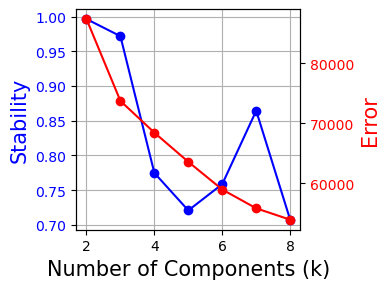

In [12]:
fig = cn.plot_stability_error(diamandis, figsize=[4,3])

fig.savefig("stability-error.pdf")  # Save figures in PDF or PNG format

## Plot GEP usage

In [13]:
diamandis.get_usages()

2                      3                          \
                   1          2           1           2           3   
sample_1   286078.50  68244.500  276585.160  53980.6300   32675.443   
sample_10  275197.88  43281.880  226840.100  32403.1540   62898.176   
sample_11  303873.50  47256.125  314960.100  34142.6600   14869.194   
sample_12  325093.12  25523.756  350777.800  11588.8520    4590.333   
sample_13  322477.56  10400.988  276273.340   3797.2440   59012.930   
...              ...        ...         ...         ...         ...   
sample_75  381357.44   4594.622   25732.727   2248.0586  324509.120   
sample_76  340674.97   8015.436   78631.260   4374.0127  243321.970   
sample_77  375865.20   5647.054   43269.070   3837.7202  303737.220   
sample_8   295867.60  26078.895  305070.660  13635.9570   16094.878   
sample_9   353053.66  24327.213  359923.300  13238.6060   18778.627   

                    4                                                 5  ...  \
                    1            2           3            4           1  ...   
sample_1   234004.080  35512.75000   27912.623   68664.3700  199742.970  ...   
sample_10  183483.560  17874.80900   59645.170   67585.2900   98527.414  ...   
sample_11  295705.060  27925.12500   11775.184   14581.3220   37954.293  ...   
sample_12  332897.660   9010.86200    2502.247    6143.3364  268559.030  ...   
sample_13  253191.270   1297.53530   57234.258   18995.1660  101381.530  ...   
...               ...          ...         ...          ...         ...  ...   
sample_75   19749.008   1229.10510  329628.440    2965.1545   10200.988  ...   
sample_76   65093.695   1876.70700  246335.900   14011.6070   25188.766  ...   
sample_77   36792.332   2210.05350  307033.340    5715.7773    9431.354  ...   
sample_8   227493.780    861.11053    9389.257  111856.4450  189603.310  ...   
sample_9   342636.720  10641.32900   15737.211    6012.1370   61335.098  ...   

                     7                          8                            \
                     6            7             1            2            3   
sample_1    52403.4020   6441.43260  32045.420000   52536.6300  196133.4000   
sample_10   22283.4960   1470.84030  14790.483000   42086.0270  172337.8300   
sample_11   26020.3950   6102.24560  27790.635000  213661.5300   24193.4860   
sample_12  256297.7200   3139.32760   3066.808600   52936.7600   11338.9840   
sample_13   27336.9000   1916.82300    678.893600  138496.6100   76755.1300   
...                ...          ...           ...          ...          ...   
sample_75    4944.2783   1597.11250   1381.631200   19430.1130    5773.4863   
sample_76    7154.2180    870.80286   1337.549100   36929.8950   58198.0470   
sample_77    6616.0854   1252.14060     50.107254    2040.0498    2556.7932   
sample_8    27486.2910  13315.35700   1030.490600   68209.4500  219052.0800   
sample_9    70786.7700   3493.91330   9673.035000  245486.4500   14767.0960   

                                                                           
                      4           5            6             7          8  
sample_1    10429.00400  48663.0820   44934.9840    7339.40430  4443.1772  
sample_10   17569.43600   8601.4580   13250.6045   83012.50000  1344.3177  
sample_11    8496.37500  16077.7040   23277.0550   23675.16200  4637.5005  
sample_12     902.53670  15865.8545  253824.5000     106.09488  2531.4177  
sample_13   44918.95700  46532.7600   24235.4570    5731.30860  1334.1672  
...                 ...         ...          ...           ...        ...  
sample_75  295478.53000  25161.4980    4616.3013    3481.89430  1453.2102  
sample_76  217495.38000   5596.7563    5735.5776   14455.64200   731.9253  
sample_77  224989.95000   1547.6853     816.1634  118176.46000   370.1014  
sample_8      704.06116  57515.4650   19949.5100     117.31553  9206.7380  
sample_9    14722.14500  10395.5680   68037.0400     509.11044  2191.7449  

[77 rows x 35 columns]

2023-03-14 12:15:02,375 [INFO] Choosing distinct colors for metadata layer patient_id
2023-03-14 12:15:02,540 [INFO] Choosing distinct colors for metadata layer simple_category
2023-03-14 12:15:02,564 [INFO] Choosing distinct colors for metadata layer detailed_category
2023-03-14 12:15:02,585 [INFO] Choosing distinct colors for metadata layer sex
2023-03-14 12:15:02,594 [INFO] Choosing distinct colors for metadata layer location of resection
2023-03-14 12:15:02,694 [INFO] Choosing distinct colors for metadata layer ATRX
2023-03-14 12:15:02,703 [INFO] Choosing distinct colors for metadata layer p53
2023-03-14 12:15:02,715 [INFO] Choosing distinct colors for metadata layer MGMT


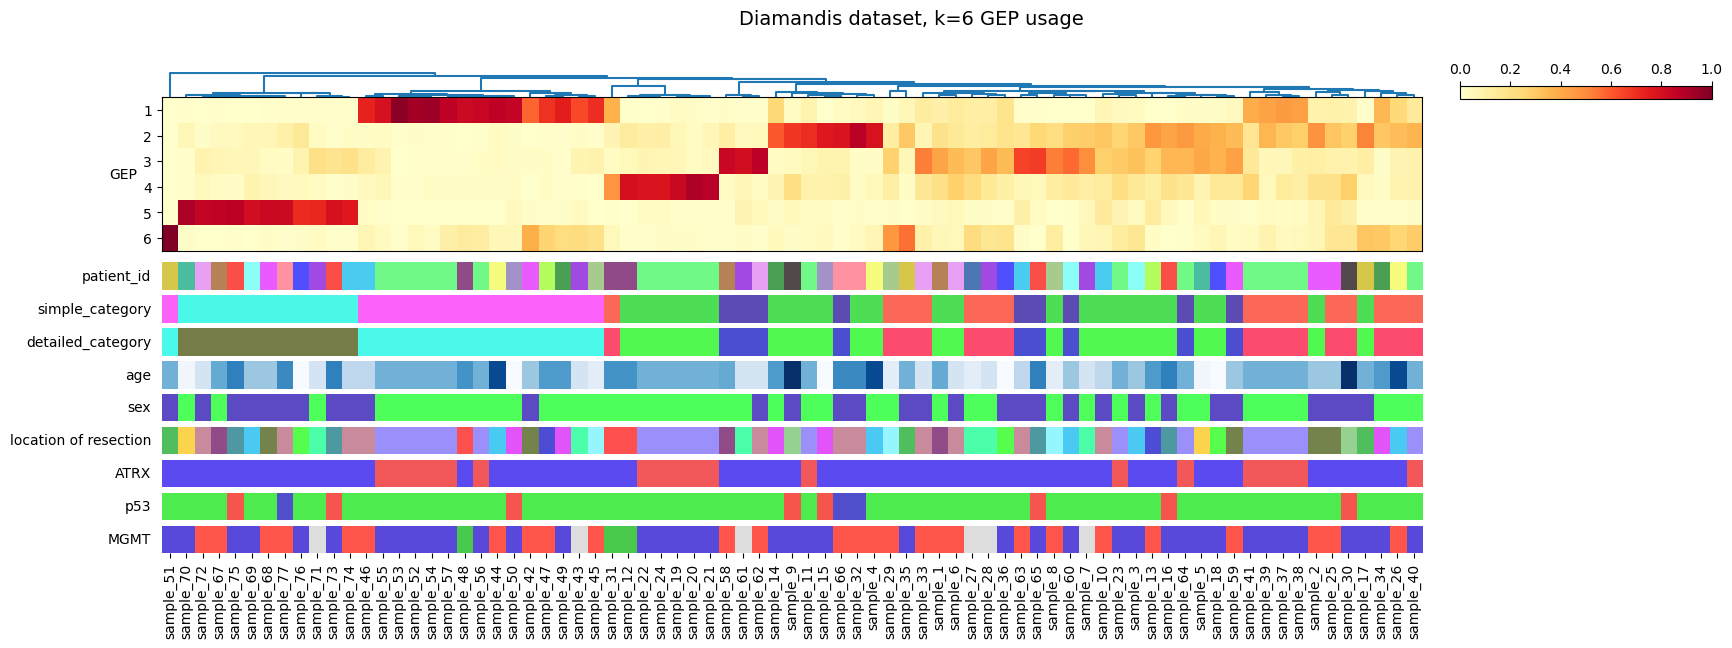

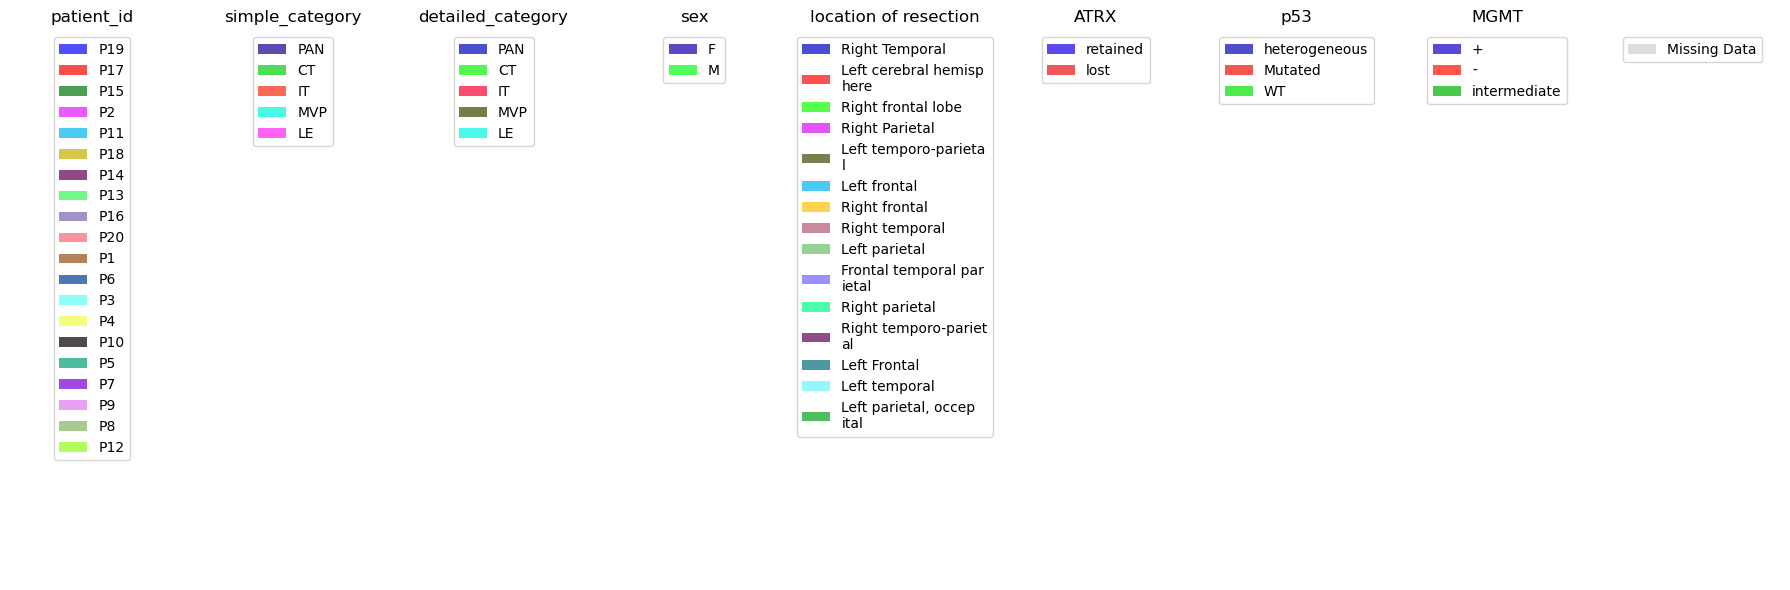

In [14]:
colors = cn.Colors.from_dataset(diamandis, pastel_factor=0.4)  # create distinct colors for metadata tracks


fig = cn.plot_usage_heatmap(diamandis, k=6, colors=colors,
                                     title="Diamandis dataset, k=6 GEP usage")
fig.savefig("k6_usages_heatmap.pdf")

fig_legend = colors.plot_metadata_colors_legend()
fig.savefig("diamandis_metadata_colors_legend.pdf")

## Factorize a second dataset for integration

In [15]:
data = pd.read_csv("cptac_data/cptac_gbm.csv", index_col=0).T  # normalized expression data
metadata = pd.read_table("cptac_data/cptac_gbm.metadata.txt", index_col=0)  # sample metadata

# create dataset from CPTAC example data
cptac = cn.Dataset.from_df(data=data, obs=metadata, is_normalized=True, patient_id_col = "patient_id")
cptac.compute_gene_stats()
cptac.select_overdispersed_genes()

# creates directory with cNMF results
cnmf_results_dir = "cnmf_results"
run_name = "cptac"
cnmf_run = cptac.initialize_cnmf(output_dir=cnmf_results_dir, name=run_name, kvals=kvals, n_iter=n_iter)
cnmf_run.factorize(verbose=False)
cnmf_run.postprocess()

# Merges cNMF results into the `Dataset` object
cptac.add_cnmf_results(cnmf_output_dir=cnmf_results_dir, cnmf_name=run_name)
cptac.write_h5ad("cptac.h5ad")  # write to h5ad file

2023-03-14 12:15:07,634 [INFO] 4554 genes selected for factorization
2023-03-14 12:17:07,024 [INFO] Factorization outputs (merged iterations) were found for all values of k.
2023-03-14 12:17:07,031 [INFO] Creating consensus GEPs and usages using 1 CPUs
2023-03-14 12:17:07,037 [INFO] Creating consensus GEPs and usages for k=2
2023-03-14 12:17:10,215 [INFO] Creating consensus GEPs and usages for k=3
2023-03-14 12:17:14,036 [INFO] Creating consensus GEPs and usages for k=4
2023-03-14 12:17:18,073 [INFO] Creating consensus GEPs and usages for k=5
2023-03-14 12:17:22,519 [INFO] Creating consensus GEPs and usages for k=6
2023-03-14 12:17:26,233 [INFO] Creating consensus GEPs and usages for k=7
2023-03-14 12:17:30,167 [INFO] Creating consensus GEPs and usages for k=8
2023-03-14 12:17:46,737 [INFO] Importing GEPs: gene_spectra_score
2023-03-14 12:17:48,732 [INFO] Importing GEPs: gene_spectra_tpm
2023-03-14 12:17:50,790 [INFO] Importing GEPs: spectra
2023-03-14 12:17:51,544 [INFO] Importing Usa

# TODO: Why is this necessary?

In [16]:
cptac.patient_id_col = "patient_id"
diamandis.patient_id_col = "patient_id"

## Integrate multiple datasets together

In [17]:
datasets = {"CPTAC": cptac,
            "Diamandis": diamandis}
integration = cn.Integration(datasets=datasets)  # create an integration object
colors = cn.Colors.from_integration(integration)  # create color scheme for metadata and datasets
colors.to_toml("colors.toml")  # save to file for reference (TOML file can be re-imported)

2023-03-14 12:17:51,908 [INFO] nancorrmp found. Calculating Pearson correlation matrix using 16 CPUs.
2023-03-14 12:17:52,673 [INFO] Choosing distinct dataset colors
2023-03-14 12:17:52,697 [INFO] Choosing distinct colors for metadata layer patient_id
2023-03-14 12:17:57,827 [INFO] Choosing distinct colors for metadata layer simple_category
2023-03-14 12:17:57,843 [INFO] Choosing distinct colors for metadata layer detailed_category
2023-03-14 12:17:57,857 [INFO] Choosing distinct colors for metadata layer multiomic
2023-03-14 12:17:57,877 [INFO] Choosing distinct colors for metadata layer r_wang_cancer_cell_2017
2023-03-14 12:17:57,894 [INFO] Choosing distinct colors for metadata layer d_methyl
2023-03-14 12:17:57,931 [INFO] Choosing distinct colors for metadata layer d_methyl_mnp
2023-03-14 12:17:57,994 [INFO] Choosing distinct colors for metadata layer is_gcimp
2023-03-14 12:17:58,004 [INFO] Choosing distinct colors for metadata layer immune
2023-03-14 12:17:58,024 [INFO] Choosing di

In [31]:
integration.k_subset

(2, 3, 4, 5, 6, 7, 8, 9, 10, 15, 20, 25, 30, 35, 40, 45, 50, 55, 60)

Identify gene overlap between datasets

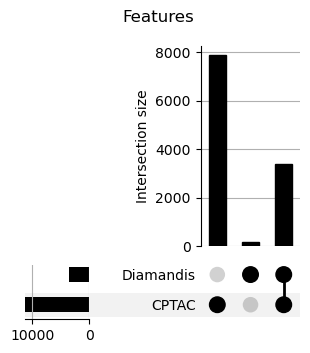

In [18]:
cn.plot_features_upset(integration)

A subset of these are identified as overdispersed in each dataset, and there is a significant overlap between datasets, indicating similar variation is seen in the two separate datasets.

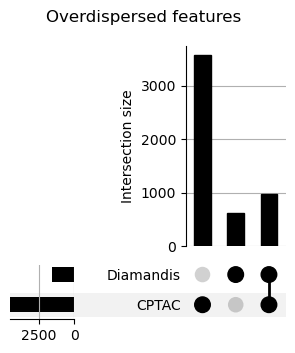

In [19]:
cn.plot_overdispersed_features_upset(integration)

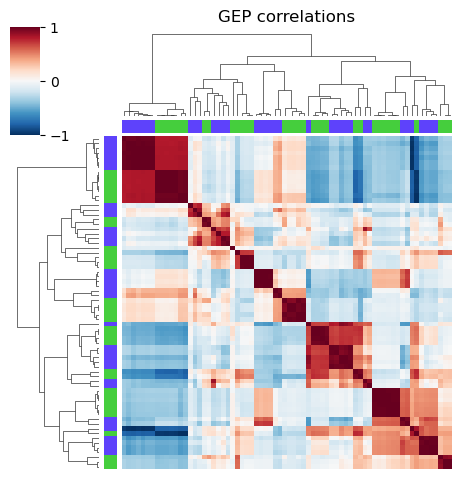

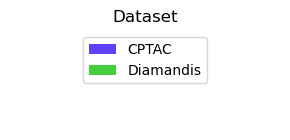

In [20]:
# plot the correlation matrix of all GEPs to each other
fig = cn.plot_gep_correlation_matrix(integration, colors=colors, figsize=[6, 6], hide_gep_labels=True)
fig.savefig("correlation_matrix.pdf")

# plot the legend separately as it applies to multiple figures
figlegend = colors.plot_dataset_colors_legend()
figlegend.savefig("datasets_legend.pdf")

To see if the `max_median_corr` threshold removed any ranks from either of the datasets, the following plot can be generated. The x-axis is the max-k, a threshold that excludes ranks above. The y-axis is the median of the correlation coefficients for all non-self edges in the correlation network. As this this threshold is slowly increased, the number of ranks, and thus nodes, and thus edges increases. The correlation between all edges slowly increases. In some datasets, this median of correlations will exceed 0 at high ranks. These high ranks will be excluded by this filter.

You can easily see for each rank whether there is a cNMF result, the stability/error of the result, as well as whether the ranks will be excluded on the basis of a max-k filter (derived from the max_median_corr parameter). You can also see which ranks will be selected (selected_k) based on automatic node subsetting for the final SNS maps.

In [21]:
integration.k_table

CPTAC                                                                  \
  cNMF result max_k_filter_pass max_k_median_corr prediction_error selected_k   
2        True              True         -0.991511     297196.53125       True   
3        True              True         -0.464217     271686.15625       True   
4        True              True         -0.361425     255362.71875       True   
5        True              True         -0.206897     241776.50000       True   
6        True              True         -0.148367     232346.28125       True   
7        True              True         -0.147034     227599.75000       True   
8        True              True         -0.125495     221241.21875       True   

              Diamandis                                                       \
  stability cNMF result max_k_filter_pass max_k_median_corr prediction_error   
2  0.992909        True              True         -0.999229     87356.328125   
3  0.893487        True              True         -0.420736     73717.257812   
4  0.688530        True              True         -0.210788     68430.921875   
5  0.674672        True              True         -0.177760     63573.480469   
6  0.622946        True              True         -0.133785     58958.609375   
7  0.546070        True              True         -0.125610     55830.250000   
8  0.518598        True              True         -0.115355     53937.726562   

                        
  selected_k stability  
2       True  0.996452  
3       True  0.971744  
4       True  0.774650  
5       True  0.720619  
6       True  0.758498  
7       True  0.864312  
8       True  0.707275

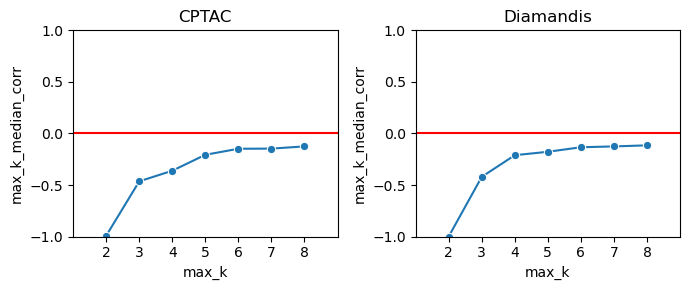

In [22]:
fig = cn.plot_rank_reduction(integration)

You can see that no k-values exceeded the threshold, so no max_k filter was applied. Now, let's plot the distribution of correlations for GEPs within and between datasets. This will show the min_corr thresholds. There is one threshold per dataset pair, and one threshold for within each dataset.

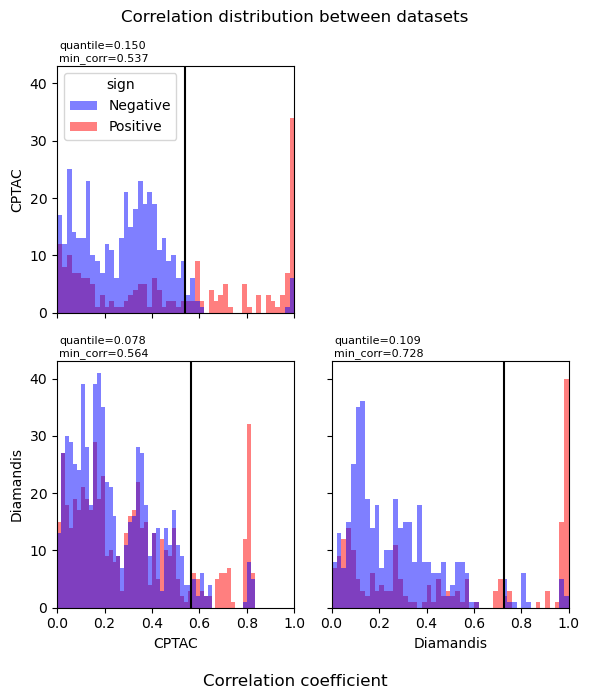

In [23]:
# fig = cn.plot_pairwise_corr(integration)
fig2 = cn.plot_pairwise_corr_overlaid(integration)  # overlaid plots show the mirrored distributions

See the number of nodes from each dataset with and without the node filters (including maxk and selectedk filters) and the edge filter (min_corr thresholds).

In [24]:
integration.get_node_table()

Node filter none         maxk         selectedk        
Edge Filter none mincorr none mincorr      none mincorr
CPTAC         35      35   35      35        35      35
Diamandis     35      35   35      35        35      35

## Create an SNS integration

2023-03-14 12:18:02,131 [INFO] Community search: algorithm = greedy_modularity, resolution = 1
2023-03-14 12:18:02,212 [INFO] Creating community network


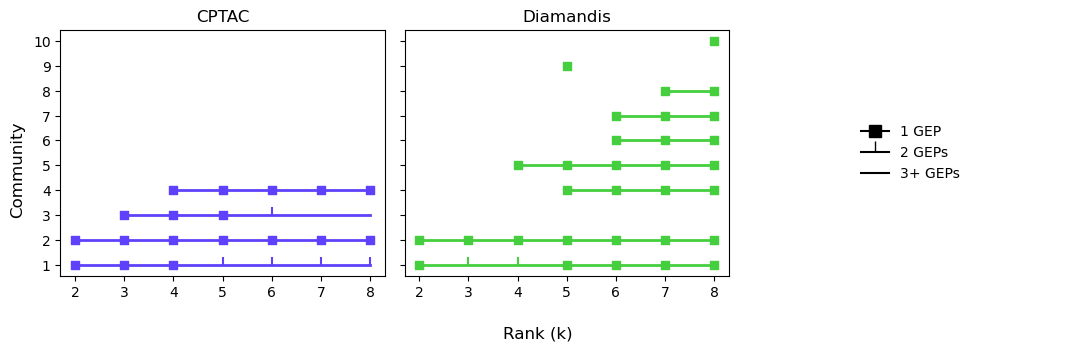

In [25]:
snsmap = cn.SNS(integration)
snsmap.community_search(algorithm="greedy_modularity", resolution=1)
fig = cn.plot_community_by_dataset_rank(snsmap, colors)

# Plot an SNS Map

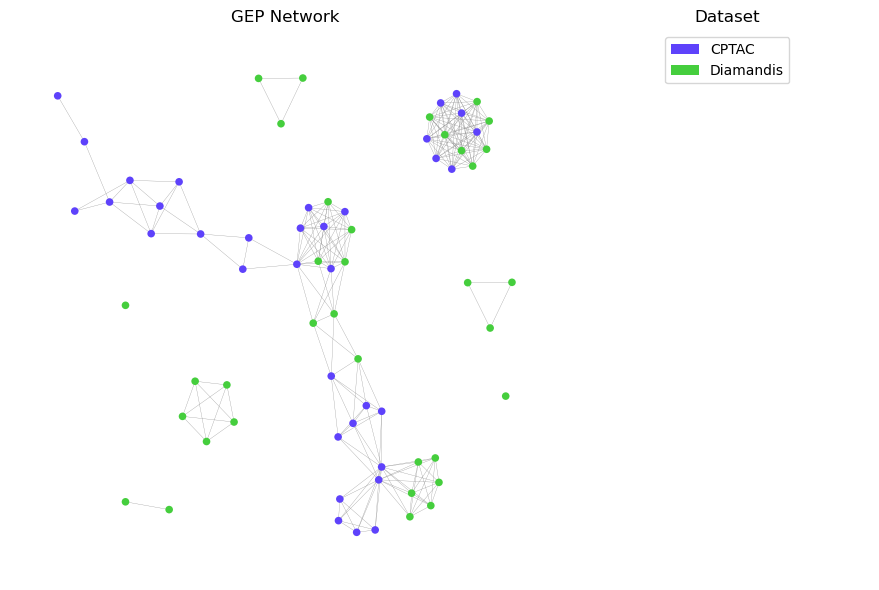

In [26]:
snsmap.compute_layout(algorithm="neato")
fig = cn.plot_gep_network_datasets(snsmap, colors, node_size_kval=False)

How many samples have each GEP/node as their highest usage GEP? 

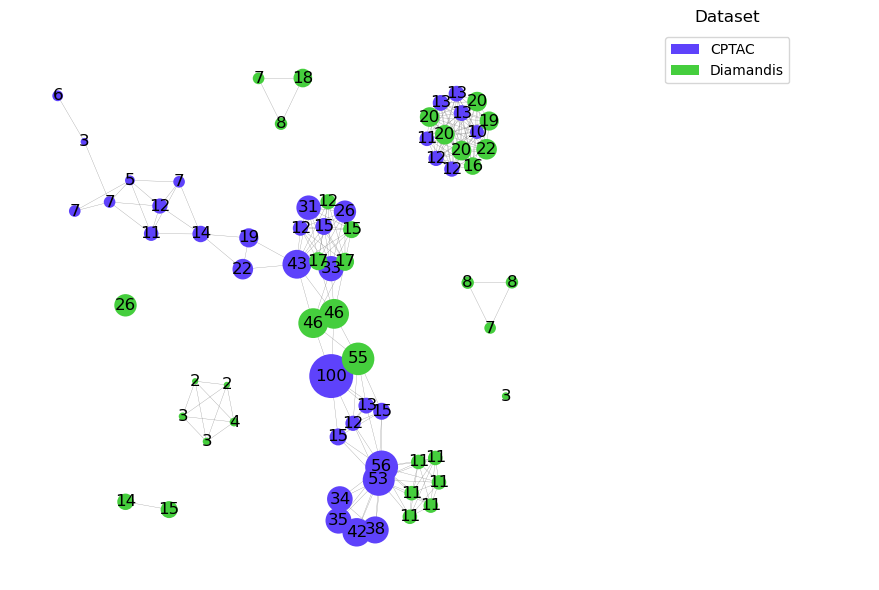

In [27]:
fig = cn.plot_gep_network_samples(snsmap,
                                  colors,
                                  node_size=1e3,
                                  font_size=12,
                                  discretize=True)

How many patients is each GEP primarily associated to?

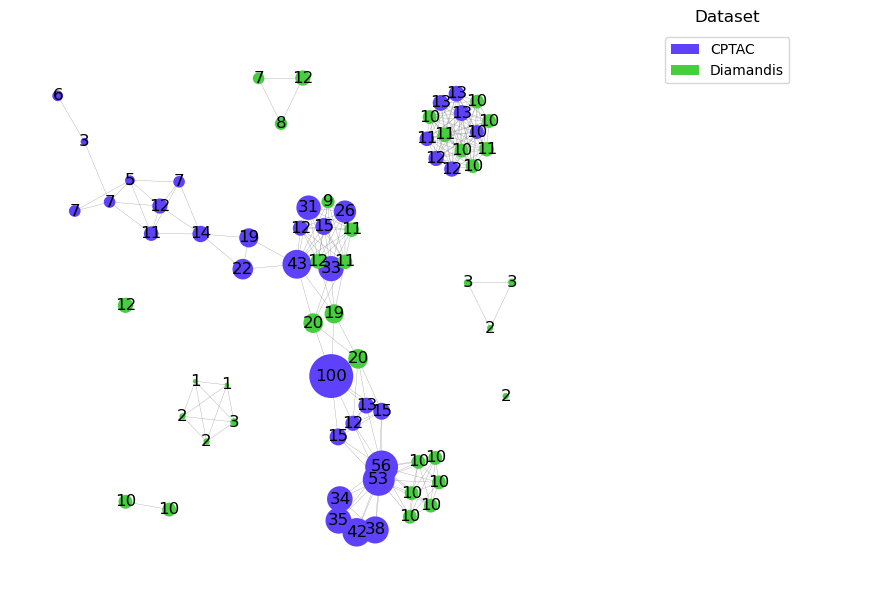

In [28]:
fig = cn.plot_npatients_gep_network(snsmap, colors, node_size=1e3, font_size=12)


Overrepresentation of sample categories for each GEP on the network

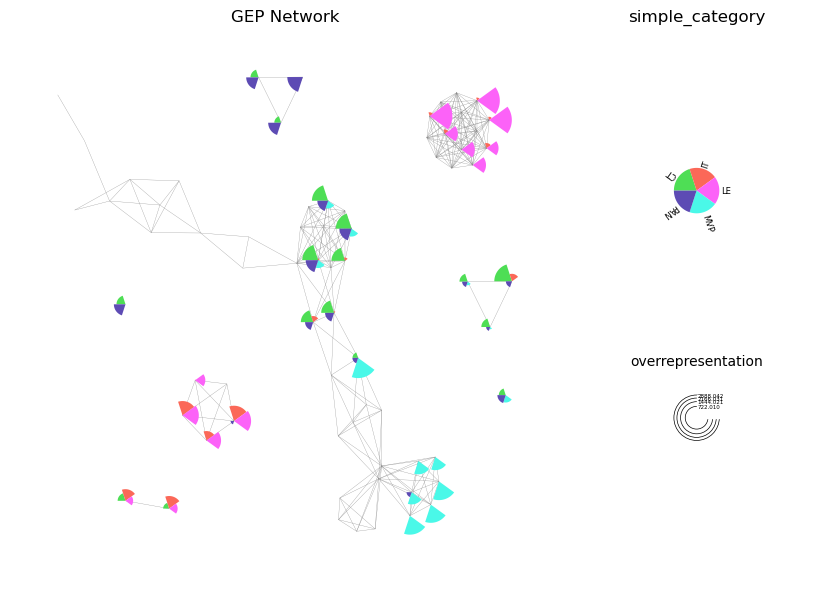

In [29]:
fig = cn.plot_overrepresentation_gep_network(snsmap, colors, subset_datasets="Diamandis", layer="simple_category")
fig.savefig("diamandis_overrepresentation.pdf")

And again, using the CPTAC annotations

In [30]:
fig = cn.plot_gep_overrepresentation_network(snsmap, colors, subset_datasets="CPTAC", layer="simple_category")
fig.savefig("cptac_overrepresentation.pdf")

AttributeError: module 'cnmfsns' has no attribute 'plot_gep_overrepresentation_network'

You can also look at continuous metadata correlated with GEP usage, like age:

# Identifying GEP Communities

2023-03-07 21:03:17,756 [INFO] Choosing distinct community colors


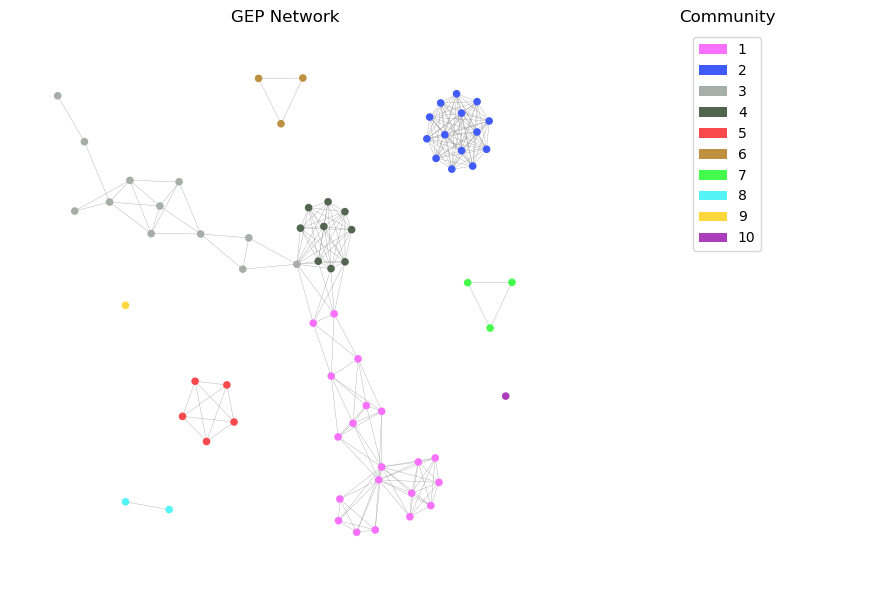

In [ ]:
colors.add_missing_community_colors(snsmap)
fig = cn.plot_gep_network_communities(snsmap, colors)

Plot a summary showing the size of each community (node size) and number of edges connecting communities (edge width).

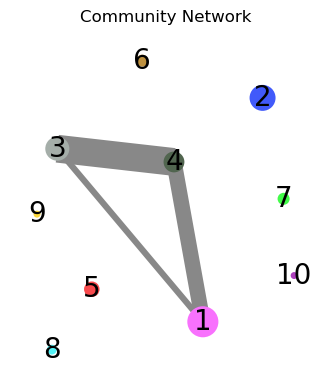

In [ ]:
fig = cn.plot_summary_community_network(snsmap, colors)

Plot GEP usage heatmap summarized by Community

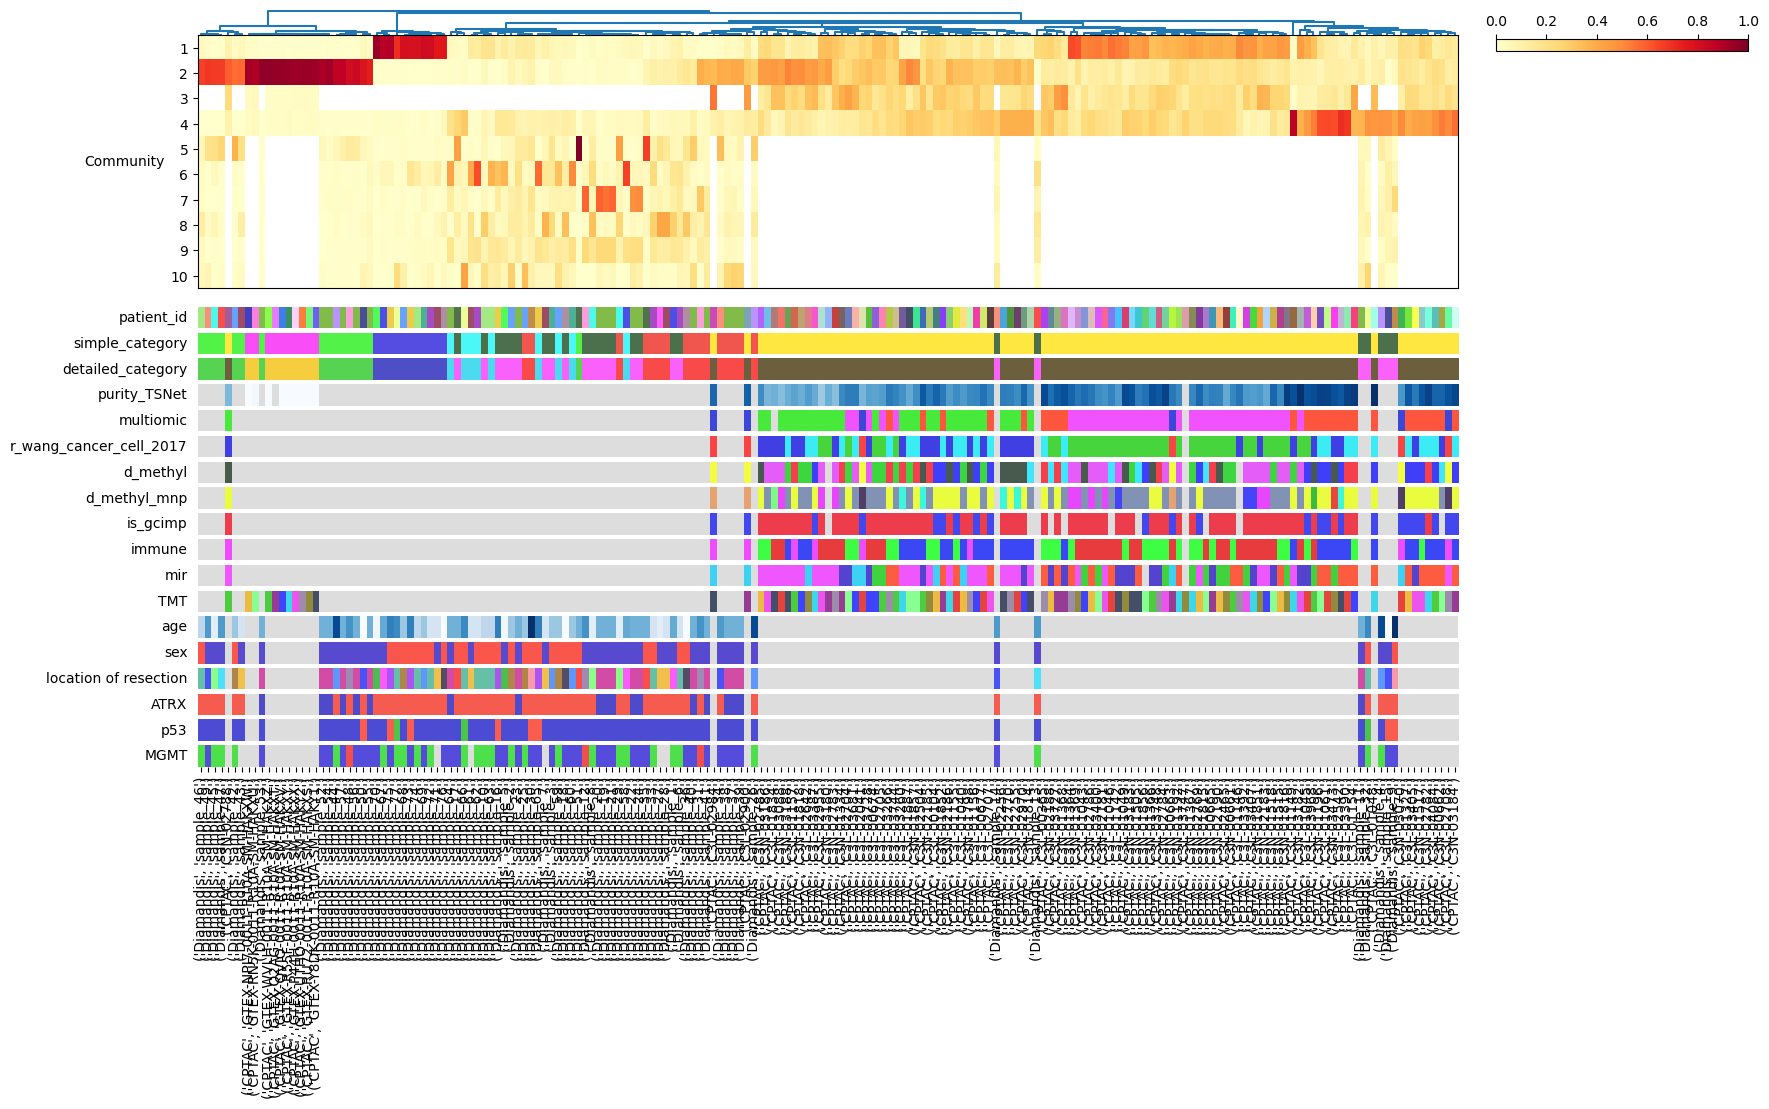

In [ ]:
fig = cn.plot_community_usage_heatmap(snsmap, colors)
# fig_legend = colors.plot_metadata_colors_legend()

## Correlation categorical variables with usage of GEPs, grouped by community

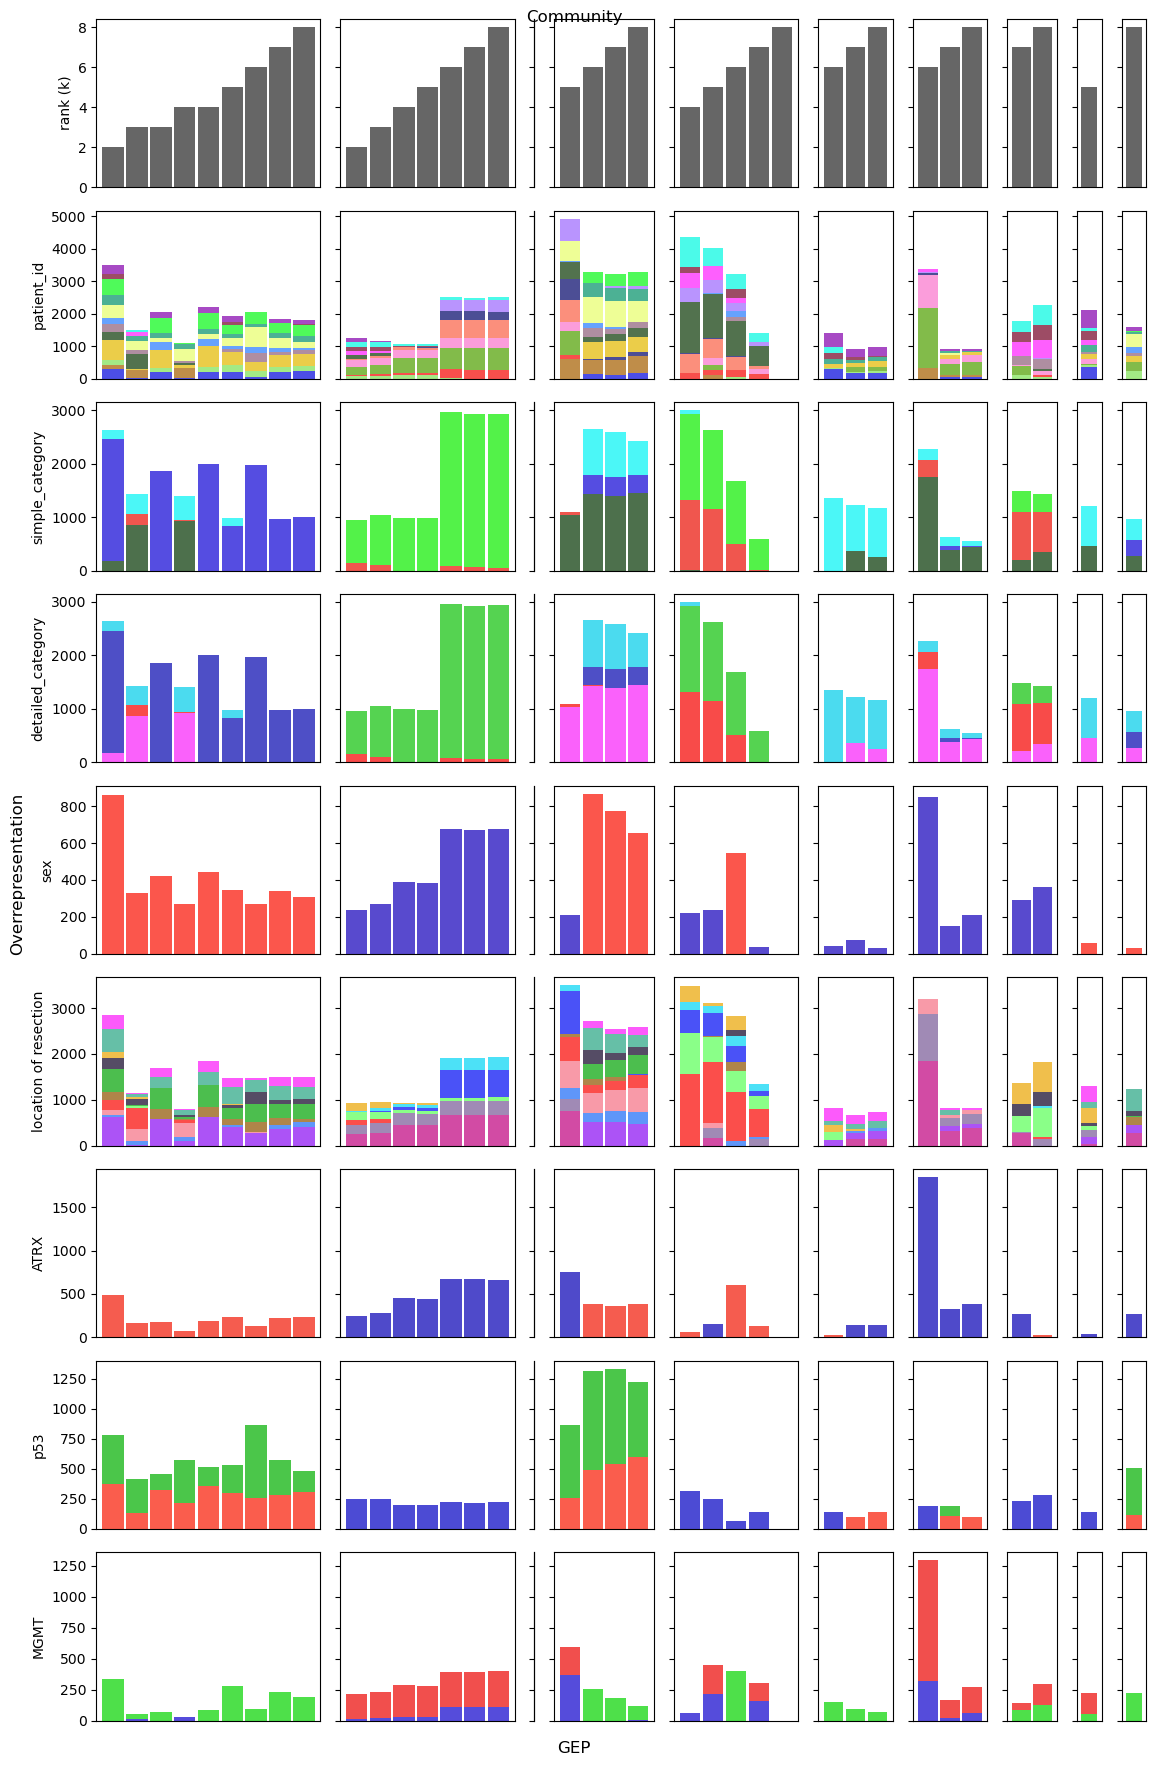

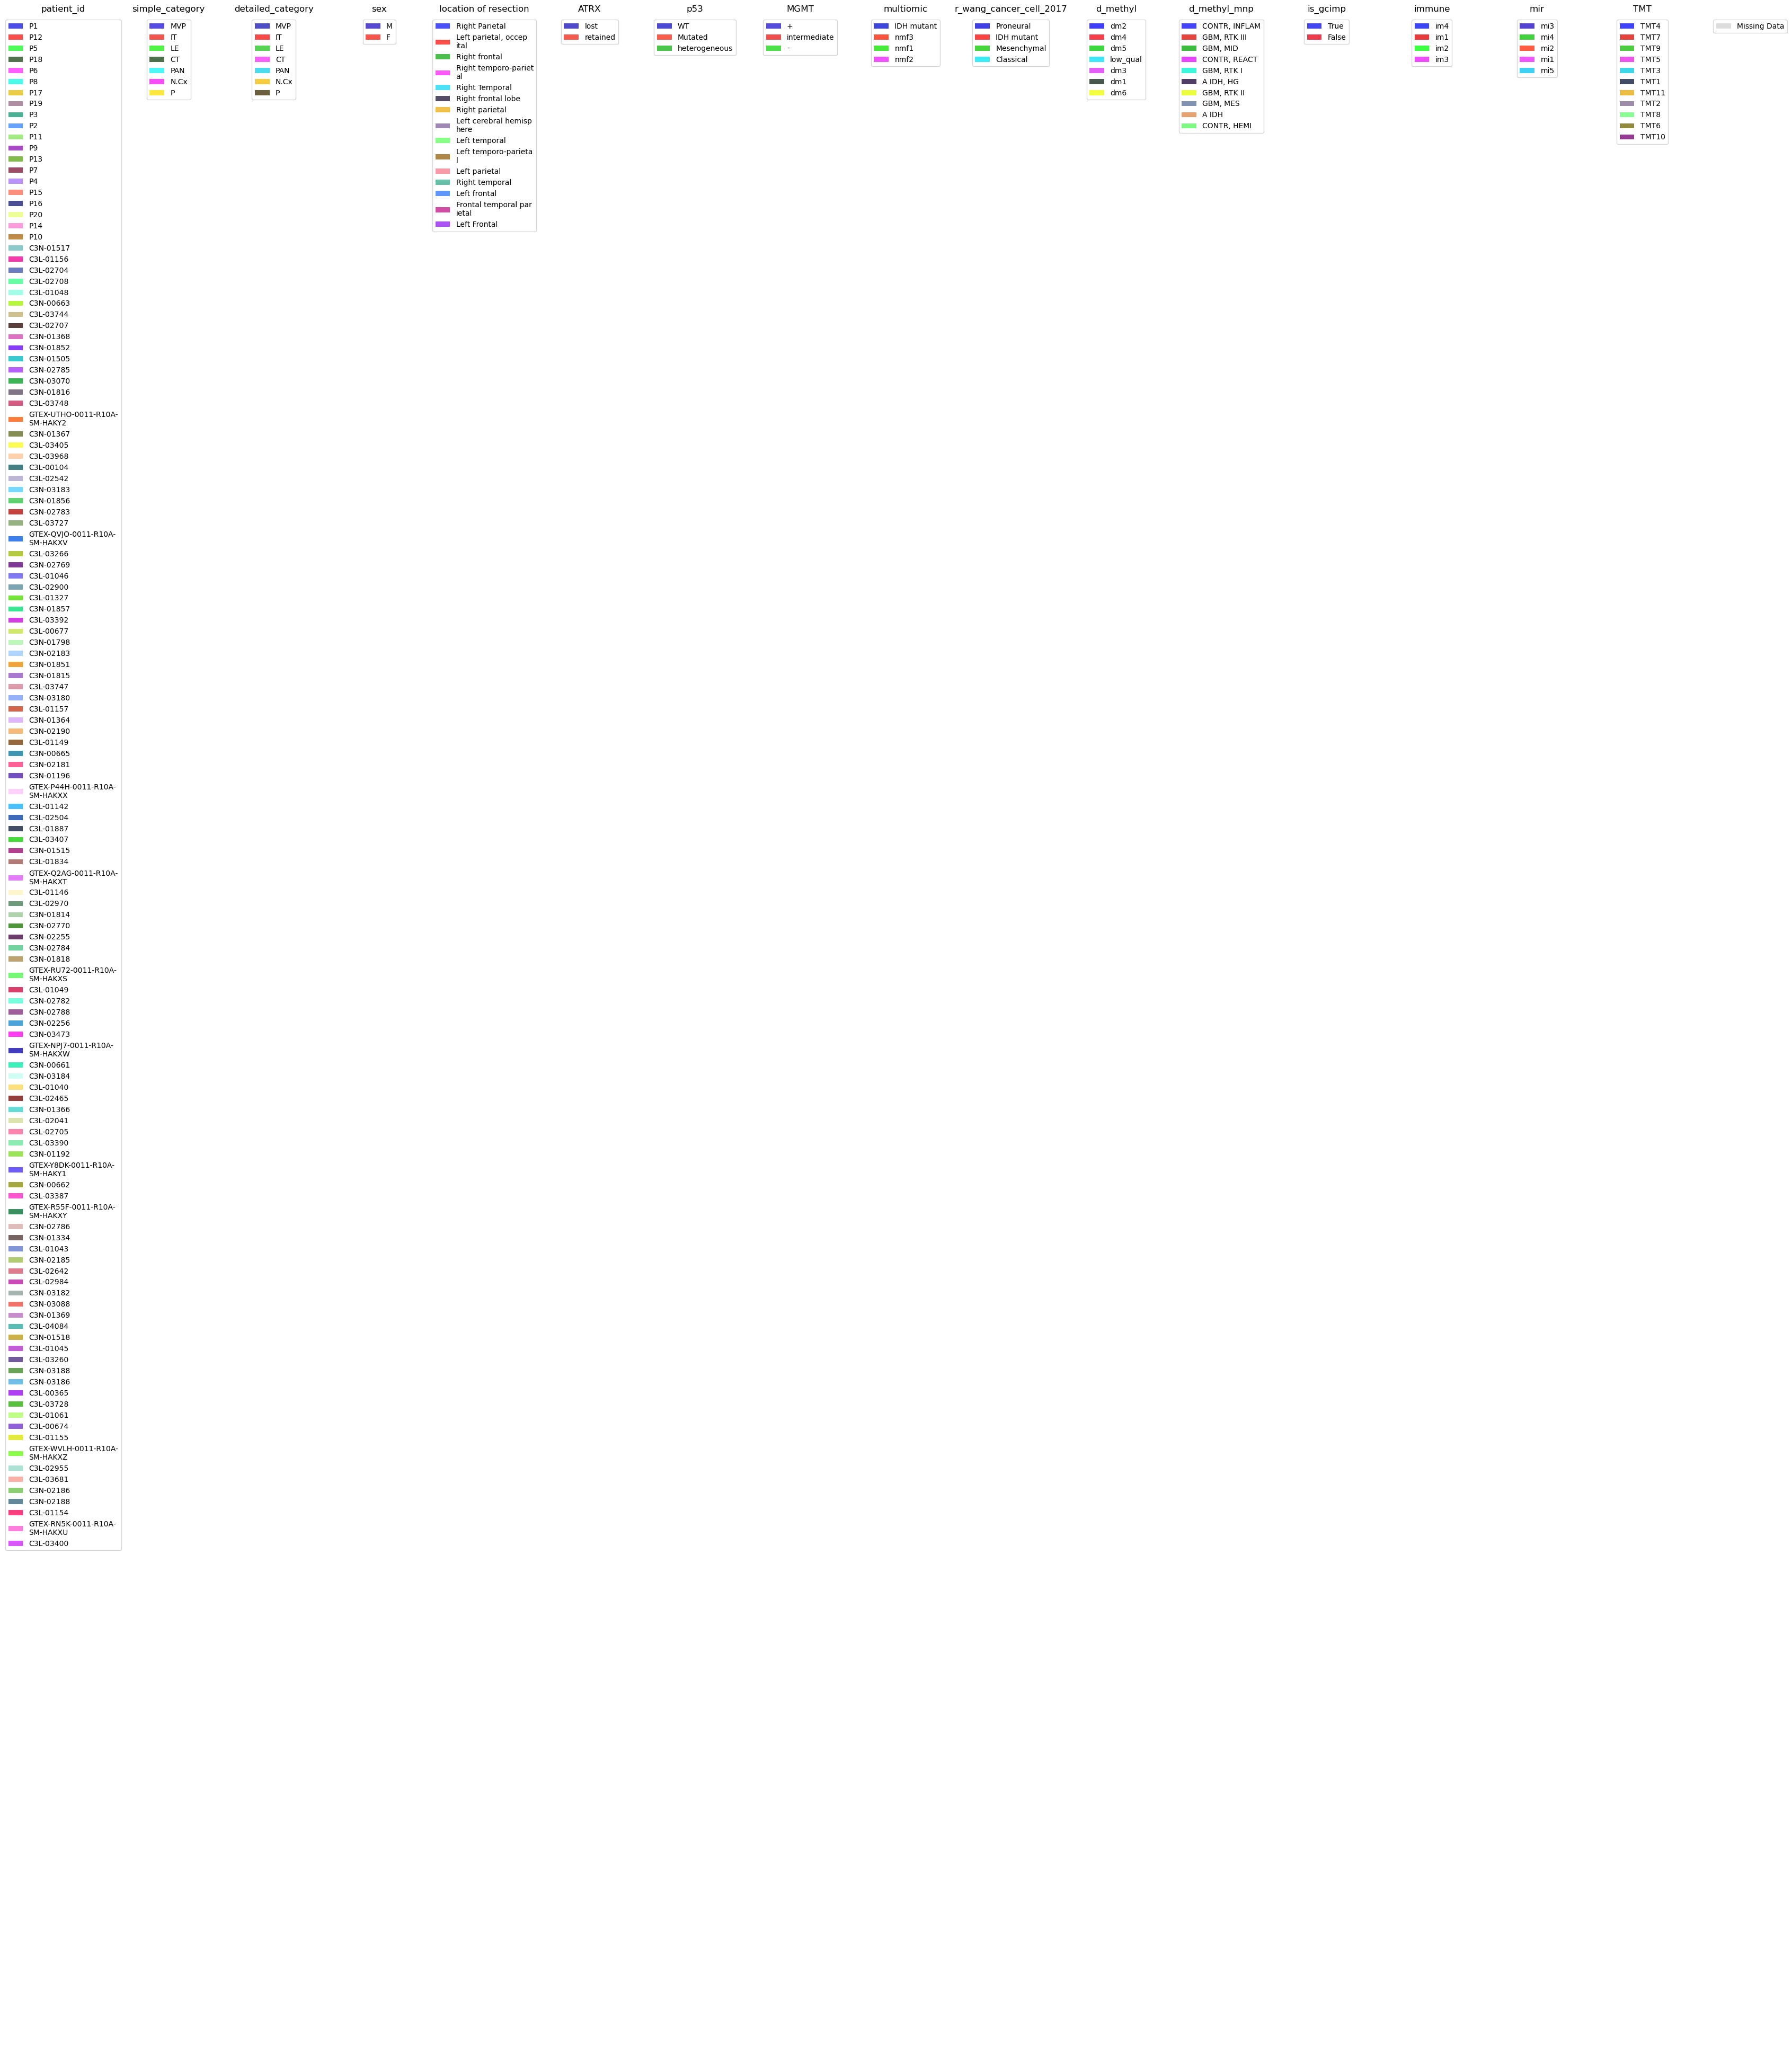

In [ ]:
fig = cn.plot_overrepresentation_gep_bar(snsmap, colors, dataset_name="Diamandis")
# fig_legend = colors.plot_metadata_colors_legend()

## Correlation GEPs in each community with continuous variables like `age`

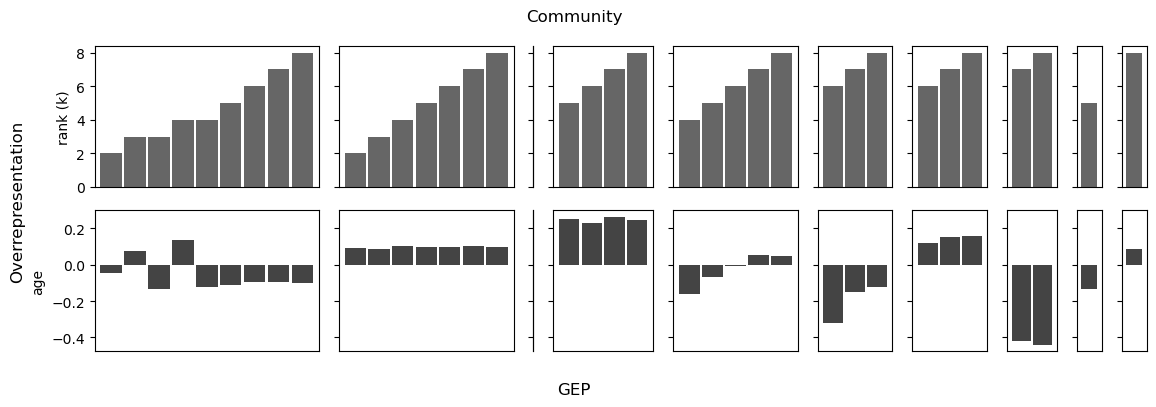

In [ ]:
fig = cn.plot_metadata_correlation_gep_bar(snsmap, colors, dataset_name="Diamandis")

# Community-level summary of overrepresentation

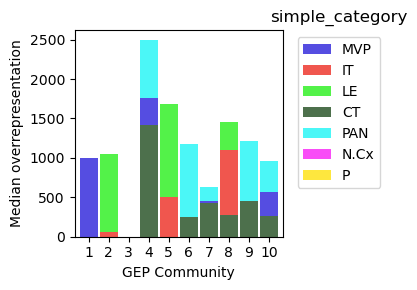

In [ ]:
fig = cn.plot_overrepresentation_community_bar(snsmap, colors, layer="simple_category", subset_datasets="Diamandis")

Or, plot it on the network:

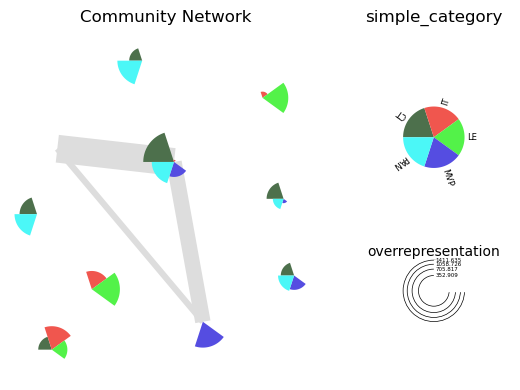

In [ ]:
fig = cn.plot_overrepresentation_community_network(snsmap, colors, layer="simple_category", pie_size=0.2, subset_datasets="Diamandis")

# Summarizing correlation with metadata

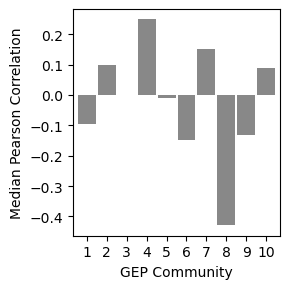

In [ ]:
fig = cn.plot_metadata_correlation_community_bar(snsmap, colors, layer="age", subset_datasets="Diamandis")

Or, plot it on the network:

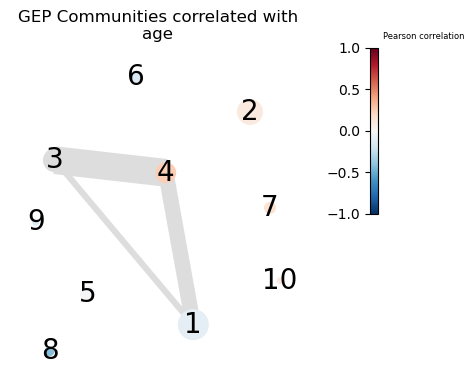

In [ ]:
fig = cn.plot_metadata_correlation_community_network(snsmap, colors, layer="age", subset_datasets="Diamandis")

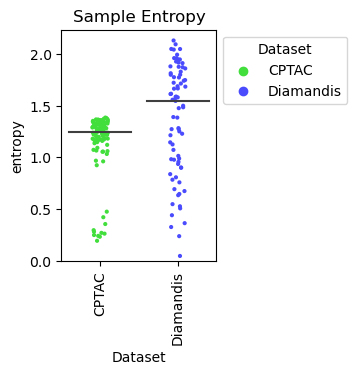

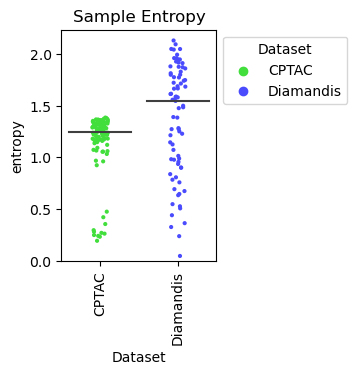

In [ ]:
cn.plot_sample_entropy(snsmap, colors)